In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [75]:
#load the mnist dataset
mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())

mnist_train.data = mnist_train.data[:5000]
mnist_train.targets = mnist_train.targets[:5000]

mnist_test.data = mnist_test.data[:500]
mnist_test.targets = mnist_test.targets[:500]


In [76]:
#create train and test loaders
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

In [77]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

In [107]:
#create a cnn architecture
class Teacher_CNN(nn.Module):
    def __init__(self):
        super(Teacher_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [108]:
#create the model
teacher_model = Teacher_CNN()
teacher_optimizer = optim.Adam(teacher_model.parameters(), lr=0.001)
teacher_loss = nn.CrossEntropyLoss()
teacher_model.to(device)

Teacher_CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [109]:
def train_model(model, train_dataloader, test_dataloader, optimizer, loss_fn, num_epochs, CUDA=False, print_accs=True):
    temp=1
    traing_accs = []
    test_accs = []

    for epoch in range(1, num_epochs+1):
        
        model.train()
        # Write training loop here
        for i, (X, y) in enumerate(train_dataloader):
            
            if CUDA:
                X = X.to(device)
                y = y.to(device)
                
            optimizer.zero_grad()
            y_pred = model(X)
            
            y_pred = nn.functional.softmax(y_pred/temp, dim=1)
            
            loss = loss_fn(y_pred, y)
            
            loss.backward()
            optimizer.step()
        
        # Calculate training accuracy
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X, y in train_dataloader:
                if CUDA:
                    X = X.to(device)
                    y = y.to(device)

                y_pred = model(X)
                
                _, predicted = torch.max(y_pred.data, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()
                
        #print(f"Epoch {epoch}, Training Accuracy: {correct / total}")
        traing_accs.append(correct / total)
        
        # Calculate test accuracy
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X, y in test_dataloader:
                if CUDA:
                    X = X.to(device)
                    y = y.to(device)

                y_pred = model(X)
                
                _, predicted = torch.max(y_pred.data, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()
                
        #print(f"Epoch {epoch}, Accuracy: {correct / total}")
        if print_accs:
            print(f"Epoch {epoch}, Training Accuracy: {traing_accs[-1]}, Validation Accuracy: {correct / total}")
        
        test_accs.append(correct / total)
        # Do not forget to use model.train() and model.eval() before training and evaluation loops respectively.
    return traing_accs, test_accs
    

In [110]:
#train the teacher model
traing_accs, test_accs = train_model(teacher_model, train_loader, test_loader, teacher_optimizer, teacher_loss, 20, CUDA=True)

/Users/loganfalzarano/anaconda3/envs/mlma/lib/python3.10/site-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1, Training Accuracy: 0.7968, Validation Accuracy: 0.752
Epoch 2, Training Accuracy: 0.8372, Validation Accuracy: 0.828
Epoch 3, Training Accuracy: 0.8476, Validation Accuracy: 0.834
Epoch 4, Training Accuracy: 0.8628, Validation Accuracy: 0.846
Epoch 5, Training Accuracy: 0.9576, Validation Accuracy: 0.948
Epoch 6, Training Accuracy: 0.9656, Validation Accuracy: 0.954
Epoch 7, Training Accuracy: 0.9696, Validation Accuracy: 0.962
Epoch 8, Training Accuracy: 0.9728, Validation Accuracy: 0.962
Epoch 9, Training Accuracy: 0.975, Validation Accuracy: 0.96
Epoch 10, Training Accuracy: 0.9788, Validation Accuracy: 0.966
Epoch 11, Training Accuracy: 0.979, Validation Accuracy: 0.97
Epoch 12, Training Accuracy: 0.9804, Validation Accuracy: 0.972
Epoch 13, Training Accuracy: 0.983, Validation Accuracy: 0.972
Epoch 14, Training Accuracy: 0.9858, Validation Accuracy: 0.97
Epoch 15, Training Accuracy: 0.9854, Validation Accuracy: 0.976
Epoch 16, Training Accuracy: 0.987, Validation Accuracy

In [111]:
#Create a new dataset with the teacher model predictions
teacher_model.eval()
teacher_input = []
teacher_predicted_probailities = []
temp = 20
with torch.no_grad():
    for X, y in train_loader:
        y_pred = teacher_model(X)
        teacher_input.append(X)
        y_pred = nn.functional.softmax(y_pred/temp, dim=1)
        teacher_predicted_probailities.append(y_pred)
        
teacher_input = torch.cat(teacher_input)
teacher_predicted_probailities = torch.cat(teacher_predicted_probailities)

In [112]:
#create new dataset
teacher_dataset = torch.utils.data.TensorDataset(teacher_input, teacher_predicted_probailities)
teacher_loader = torch.utils.data.DataLoader(teacher_dataset, batch_size=100, shuffle=True)

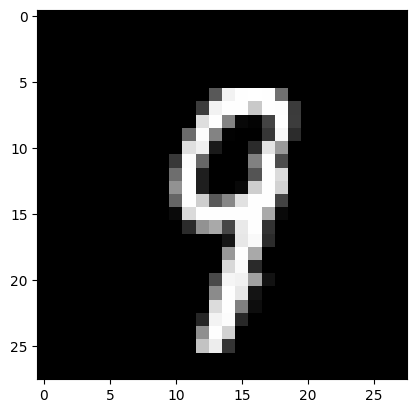

In [113]:
f = 85
#plot the first image

plt.imshow(teacher_input[f].squeeze().numpy(), cmap='gray')
plt.show()

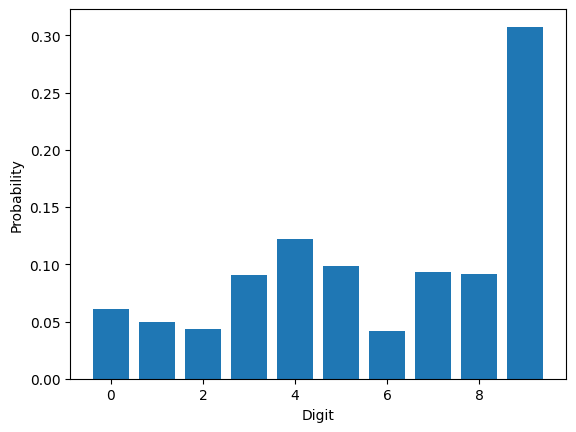

array([0.06126883, 0.049483  , 0.04352243, 0.09105039, 0.12199786,
       0.09857655, 0.04131078, 0.0935174 , 0.09166567, 0.3076071 ],
      dtype=float32)

In [114]:
#plot the first image probabilities
plt.bar(range(10), teacher_predicted_probailities[f].numpy())
plt.xlabel('Digit')
plt.ylabel('Probability')
plt.show()

teacher_predicted_probailities[f].numpy()


In [115]:
#create a cnn architecture
class Teacher_CNN(nn.Module):
    def __init__(self):
        super(Teacher_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [116]:
#create student model
student_model = Teacher_CNN()
student_optimizer = optim.Adam(student_model.parameters(), lr=0.001)
student_loss = nn.KLDivLoss()
# student_loss = nn.CrossEntropyLoss()

In [117]:
def train_model_student(model, train_dataloader, test_dataloader, optimizer, loss_fn, num_epochs, CUDA=False, print_accs=True):
    temp = 1

    traing_accs = []
    test_accs = []

    for epoch in range(1, num_epochs+1):
        
        model.train()
        # Write training loop here
        for i, (X, y,) in enumerate(train_dataloader):
            
            if CUDA:
                X = X.cuda()
                y = y.cuda()

            optimizer.zero_grad()
            y_pred = model(X)
            
            y_pred = nn.functional.log_softmax(y_pred/temp, dim=1)
            
            loss = loss_fn(y_pred, y)
            
            loss.backward()
            optimizer.step()

        # Write evaluation loop(s) here
        
        # Calculate training accuracy
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X, y in train_dataloader:
                if CUDA:
                    X = X.cuda()
                    y = y.cuda()

                y_pred = model(X)
                
                _, predicted = torch.max(y_pred.data, 1)
                _, true_classes = torch.max(y, dim=1)
                
                total += y.size(0)
                correct += (predicted == true_classes).sum().item()
                
        #print(f"Epoch {epoch}, Training Accuracy: {correct / total}")
        traing_accs.append(correct / total)
        
        # Calculate test accuracy
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X, y in test_dataloader:
                if CUDA:
                    X = X.cuda()
                    y = y.cuda()

                y_pred = model(X)
                
                _, predicted = torch.max(y_pred.data, 1)
                
                total += y.size(0)
                correct += (predicted == y).sum().item()
                
        #print(f"Epoch {epoch}, Accuracy: {correct / total}")
        if print_accs:
            print(f"Epoch {epoch}, Training Accuracy: {traing_accs[-1]}, Validation Accuracy: {correct / total}")
        
        test_accs.append(correct / total)
        # Do not forget to use model.train() and model.eval() before training and evaluation loops respectively.
    return traing_accs, test_accs
    

In [118]:
#create random tensor
random_tensor = torch.rand(10, 2)
print(random_tensor)
a, b = torch.max(random_tensor, 1)

print(a,b)

tensor([[0.2393, 0.5825],
        [0.8787, 0.7441],
        [0.8012, 0.1292],
        [0.1938, 0.9677],
        [0.6410, 0.5631],
        [0.3651, 0.0690],
        [0.2210, 0.5649],
        [0.7002, 0.8907],
        [0.1427, 0.9006],
        [0.6732, 0.2515]])
tensor([0.5825, 0.8787, 0.8012, 0.9677, 0.6410, 0.3651, 0.5649, 0.8907, 0.9006,
        0.6732]) tensor([1, 0, 0, 1, 0, 0, 1, 1, 1, 0])


In [119]:
#train the student model
traing_accs, test_accs = train_model_student(student_model, teacher_loader, test_loader, student_optimizer, student_loss, 30)

/Users/loganfalzarano/anaconda3/envs/mlma/lib/python3.10/site-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/Users/loganfalzarano/anaconda3/envs/mlma/lib/python3.10/site-packages/torch/nn/functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 1, Training Accuracy: 0.9436, Validation Accuracy: 0.924
Epoch 2, Training Accuracy: 0.97, Validation Accuracy: 0.948
Epoch 3, Training Accuracy: 0.977, Validation Accuracy: 0.956
Epoch 4, Training Accuracy: 0.9802, Validation Accuracy: 0.956
Epoch 5, Training Accuracy: 0.9848, Validation Accuracy: 0.964
Epoch 6, Training Accuracy: 0.9828, Validation Accuracy: 0.968
Epoch 7, Training Accuracy: 0.986, Validation Accuracy: 0.964
Epoch 8, Training Accuracy: 0.9876, Validation Accuracy: 0.97
Epoch 9, Training Accuracy: 0.9866, Validation Accuracy: 0.966
Epoch 10, Training Accuracy: 0.9876, Validation Accuracy: 0.97
Epoch 11, Training Accuracy: 0.9886, Validation Accuracy: 0.972
Epoch 12, Training Accuracy: 0.9894, Validation Accuracy: 0.968
Epoch 13, Training Accuracy: 0.9908, Validation Accuracy: 0.968
Epoch 14, Training Accuracy: 0.989, Validation Accuracy: 0.966
Epoch 15, Training Accuracy: 0.9912, Validation Accuracy: 0.962
Epoch 16, Training Accuracy: 0.9916, Validation Accuracy

In [ ]:
from fgsm import create_fgsm_adversarial_example
from fgsm import can_import

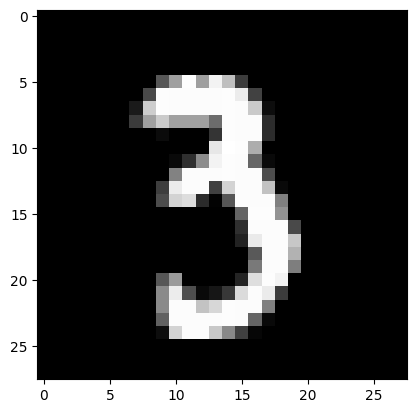

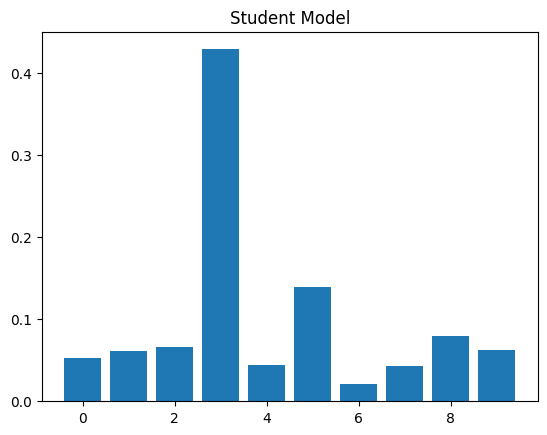

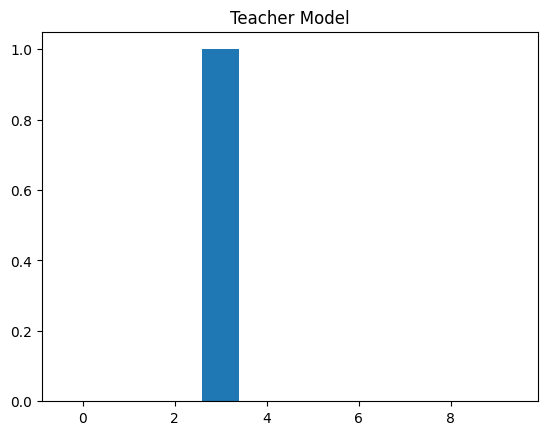

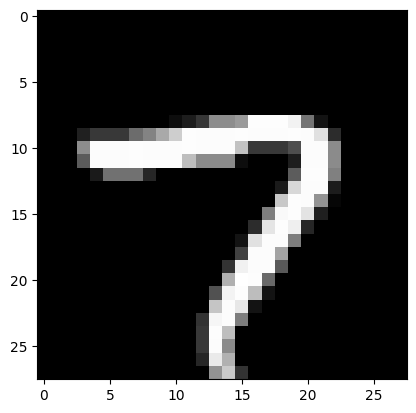

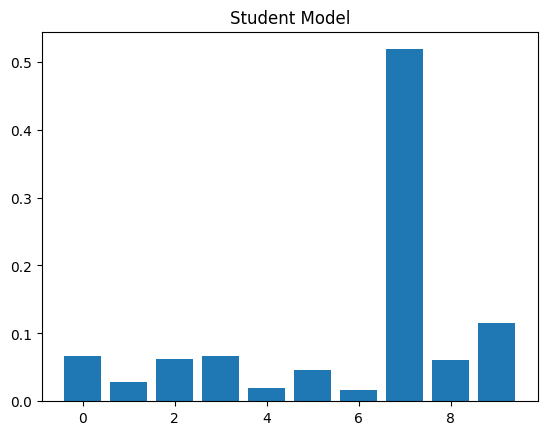

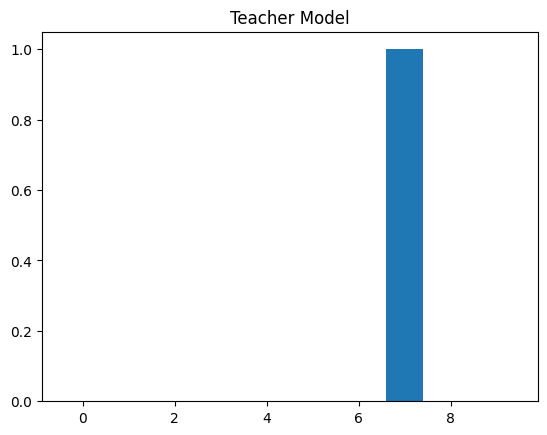

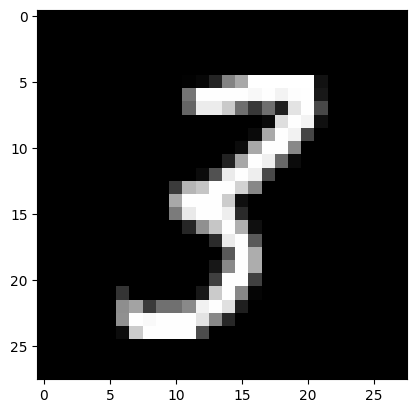

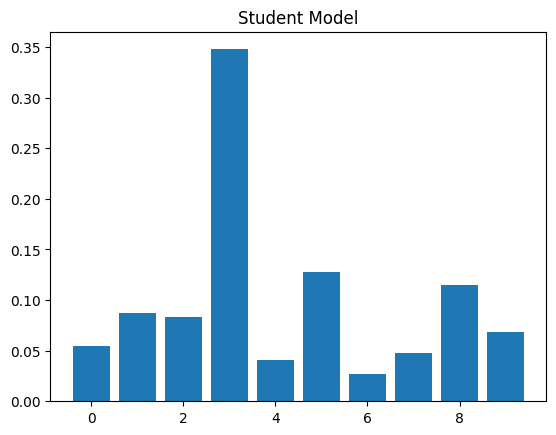

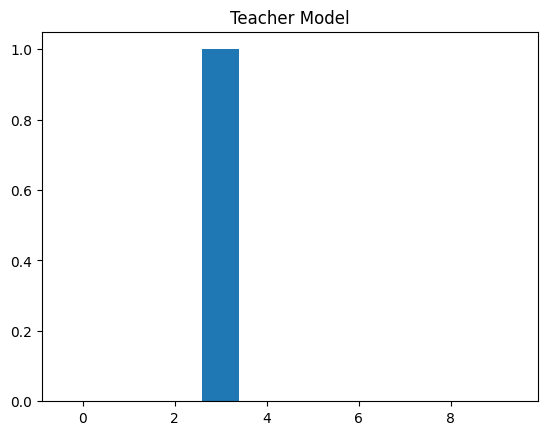

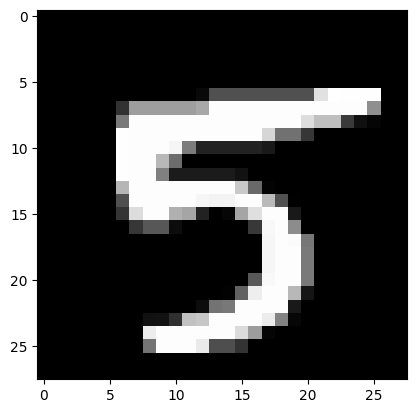

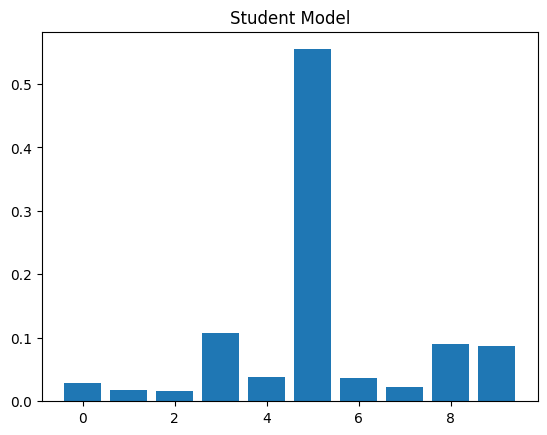

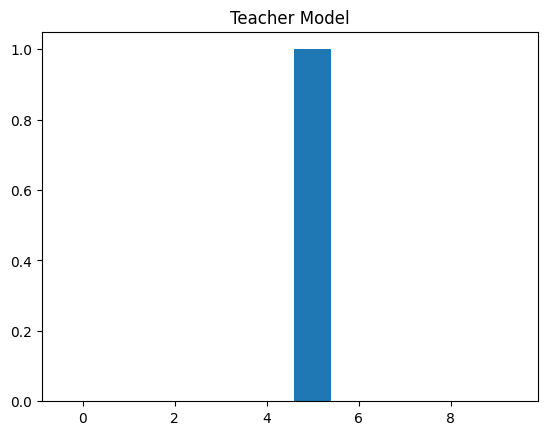

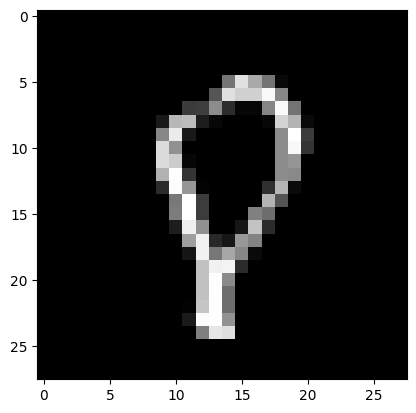

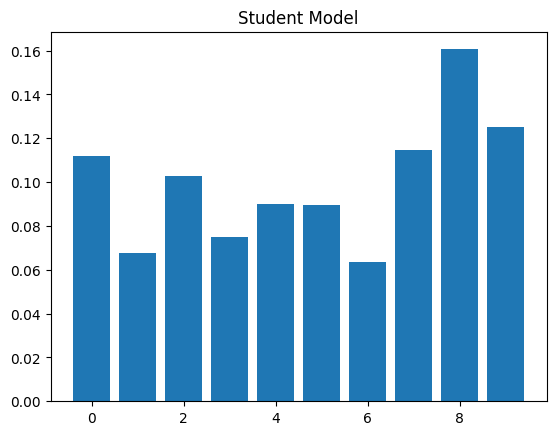

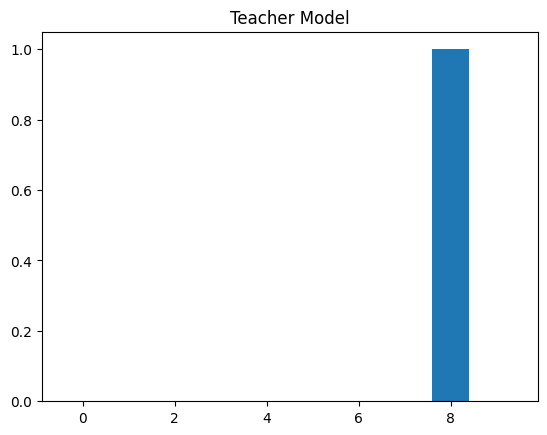

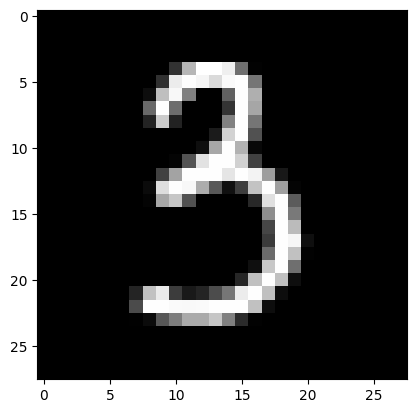

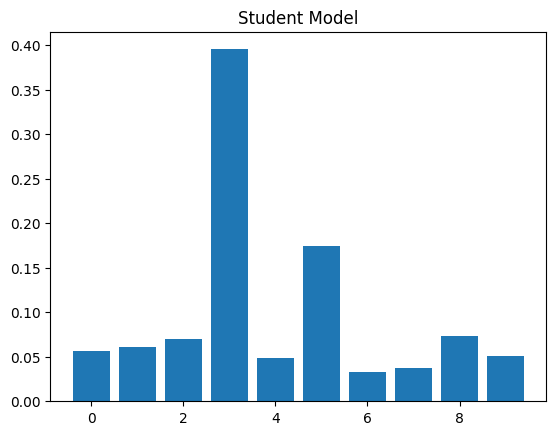

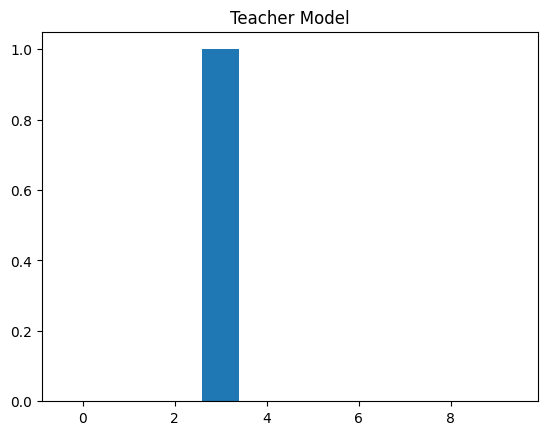

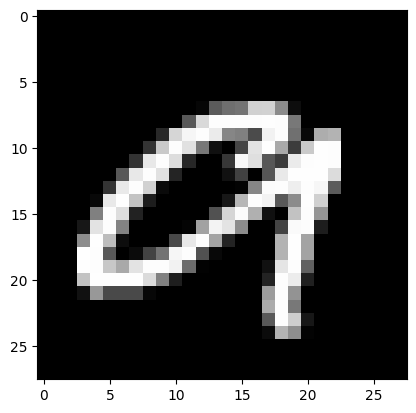

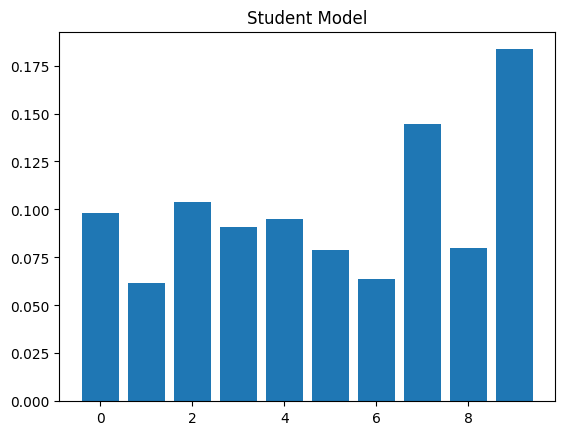

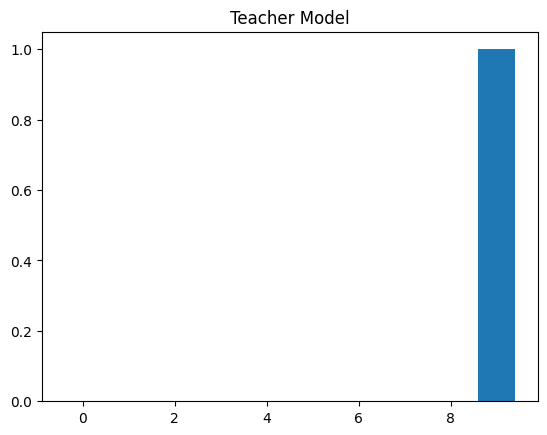

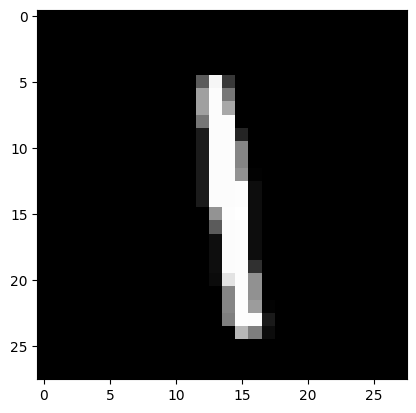

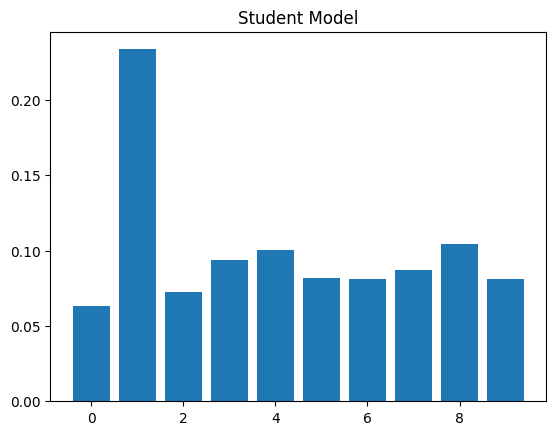

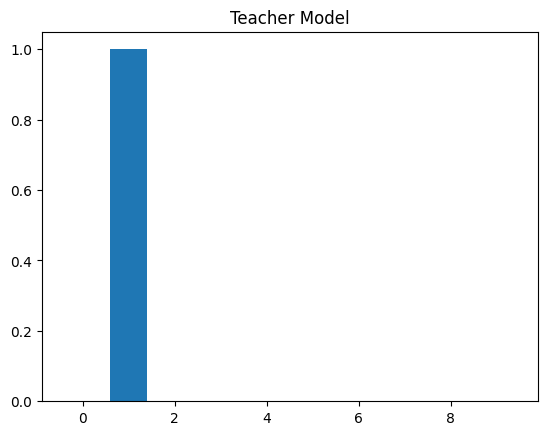

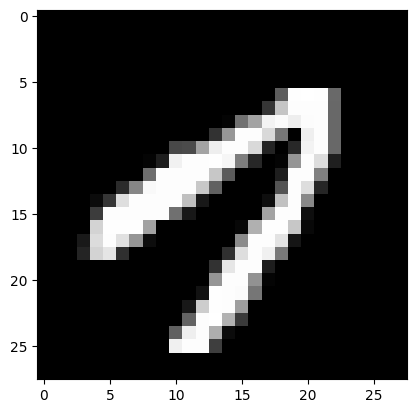

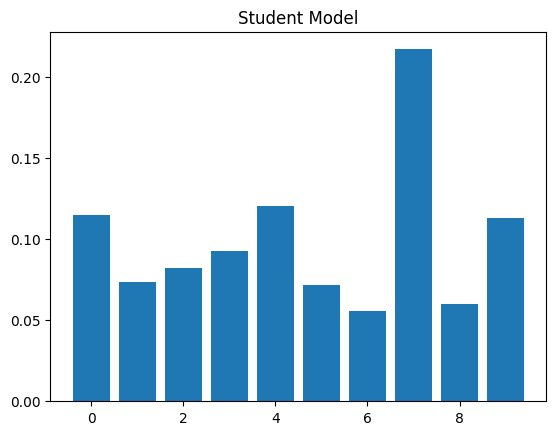

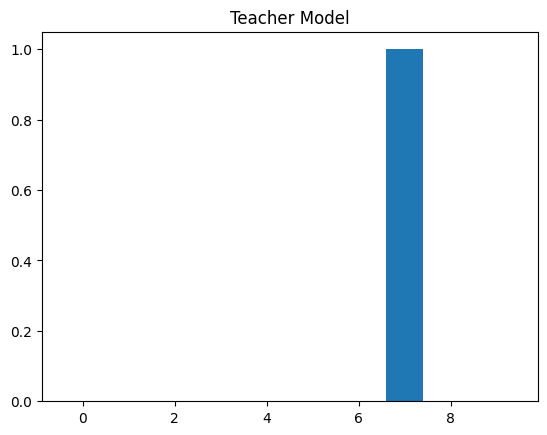

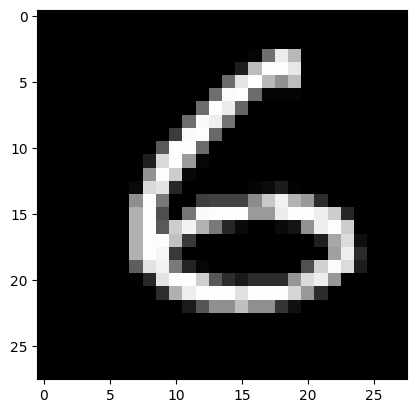

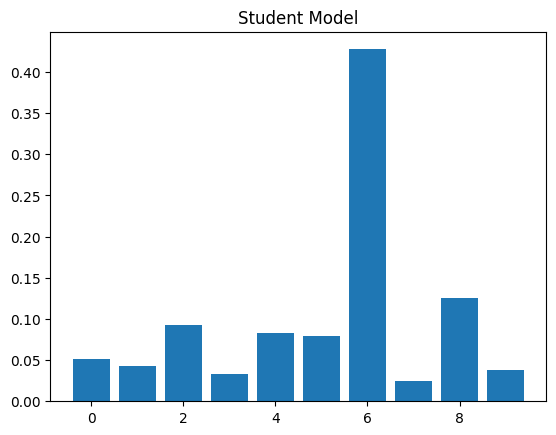

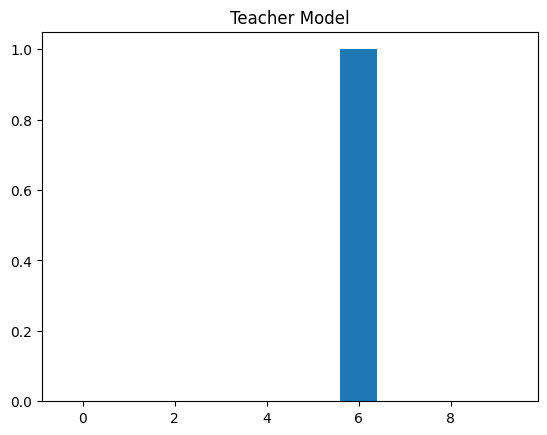

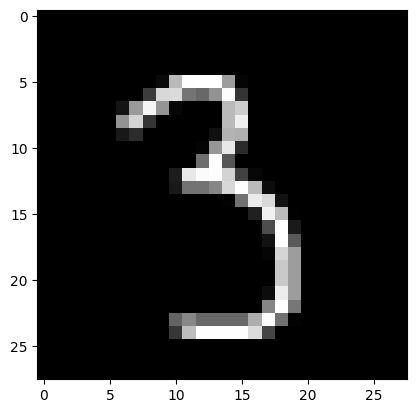

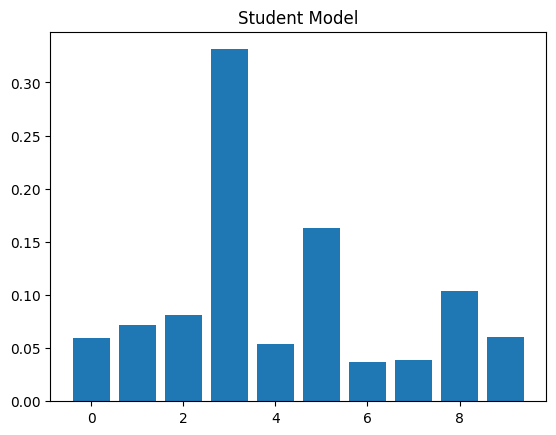

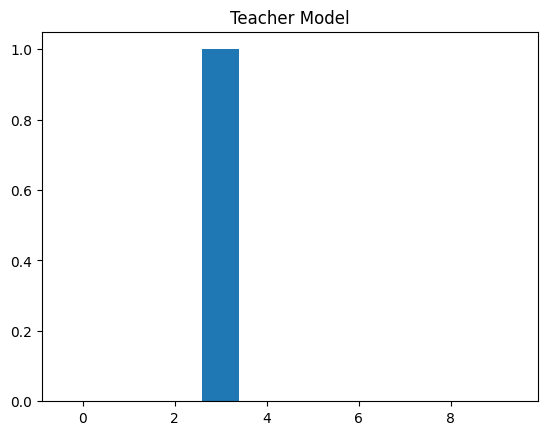

In [120]:
#get image from the test set
counter = 0
for X, y in train_loader:
    #get prediction from the student model
    y_pred_student = student_model(X)
    y_pred_teacher = teacher_model(X)
    
    #plot the image
    plt.imshow(X[0].squeeze().numpy(), cmap='gray')
    plt.show()
    
    #plot both predictions
    plt.bar(range(10), nn.functional.softmax(y_pred_student[0], dim=0).detach().numpy())
    plt.title('Student Model')
    plt.show()
    
    plt.bar(range(10), nn.functional.softmax(y_pred_teacher[0], dim=0).detach().numpy())
    plt.title('Teacher Model')
    plt.show()
    
    if counter == 10:
        break
    
    counter += 1

In [22]:
def create_fgsm_adversarial_example(model, criterion, X, y, epsilon):
    X.requires_grad = True
    model.zero_grad()
    #retain gradient
    X.retain_grad()
    output = model(X)
    model_prediction_unperturbed = output.argmax(dim=1)
    prediction_confidence = F.softmax(output, dim=1).max()
    loss = criterion(output, y)
    loss.backward()
    x_grad = X.grad.data
    print("gradient is here")
    print(x_grad)
    x_adv = X + epsilon * x_grad.sign()
    return model_prediction_unperturbed, prediction_confidence, x_adv

gradient is here
tensor([[[ 5.3562e-07,  1.4435e-06, -4.9914e-10,  8.7588e-09, -1.7413e-06,
          -4.3899e-07, -1.9381e-06, -2.9192e-06, -3.1431e-06, -1.3202e-06,
           1.8724e-06, -9.6280e-07,  4.1975e-06, -5.5607e-07,  4.9291e-07,
          -2.6576e-06, -2.1121e-06, -4.1148e-06,  1.3394e-06, -1.1785e-06,
           5.0557e-06,  2.4015e-06,  2.4170e-06,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 1.9107e-06,  1.7600e-06,  1.1395e-06,  7.7370e-07, -1.7813e-06,
          -3.5324e-08,  8.9061e-07, -4.2201e-07, -2.1376e-06, -6.8654e-07,
          -5.1312e-06, -2.6831e-06, -3.3418e-06, -1.2575e-06,  8.7535e-07,
          -9.9857e-07, -2.5843e-06, -2.8976e-06, -4.5417e-06, -2.0051e-06,
           6.1268e-07,  7.4032e-07,  9.3383e-07,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 1.5442e-06,  3.8411e-09,  9.4415e-07, -2.0259e-06, -1.8786e-06,
           6.3730e-07,  3.9845e-06, -1.7086e-06, -4.0774e-

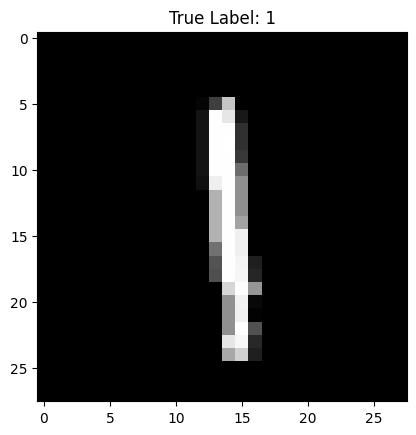

In [23]:
a =8
#create an adversarial example
input_label = train_loader.dataset[a][1]

#convert y to tensor
y_tensor = torch.tensor([input_label])

model_prediction_unperturbed, prediction_confidence, x_adv = create_fgsm_adversarial_example(teacher_model, teacher_loss, train_loader.dataset[a][0], y_tensor, epsilon=0.1)


#plot the orginal image
plt.imshow(train_loader.dataset[a][0].squeeze().numpy(), cmap='gray')
plt.title(f'True Label: {input_label}')
plt.show()

In [ ]:
#plot the adversarial image
plt.imshow(x_adv.squeeze().detach().numpy(), cmap='gray')

In [ ]:
print(x_adv.shape)

In [ ]:
#make a prediction on the orginal image
teacher_output = teacher_model(x_adv)
#apply softmax
teacher_output = F.softmax(teacher_output, dim=1)
#convert to numpy array
teacher_output = teacher_output.detach().numpy()
#plot student output
plt.bar(range(10), teacher_output[0])
plt.xlabel('Digit')
plt.ylabel('Probability')
plt.title("Teacher Model predicted probalities")
plt.show()

student_output = student_model(x_adv)
# apply softmax
student_output = F.softmax(student_output, dim=1)
# convert to numpy array
student_output = student_output.detach().numpy()

# plot student output
plt.bar(range(10), student_output[0])
plt.xlabel('Digit')
plt.ylabel('Probability')
plt.title("Student Model predicted probalities")
plt.show()


### We can see here that the teach model incorrectly predicts class 2 for the image whereas the student model is able to correctly classify the perturbed image. This is a clear indication that the student model is more robust to adversarial attacks than the teacher model.

In [ ]:
def evaluate_model_on_adversarial_input(model, model_criterion, test_dataloader, epsilon=0.1):
    
    #set batch size of 1
    test_dataloader = torch.utils.data.DataLoader(test_dataloader.dataset, batch_size=1, shuffle=False)
    
    raw_image_prections = []
    adv_image_predictions = []
    true_labels = []
    
    for X, y in test_dataloader:
        
        X = X.to(device)
        y = y.to(device)
        
        true_labels.append(y)
        
        #get the predictions on the raw image
        raw_image_prediction = model(X)
        _, raw_image_predicted = torch.max(raw_image_prediction.data, 1)
        raw_image_prections.append(raw_image_predicted)
        
        #create adversarial example
        _, _, x_adv = create_fgsm_adversarial_example(model, model_criterion, X, y, epsilon)
        
        #get the predictions on the adversarial image
        adv_image_prediction = model(x_adv)
        _, adv_image_predicted = torch.max(adv_image_prediction.data, 1)
        adv_image_predictions.append(adv_image_predicted)
            
    #concatenate the predictions
    raw_image_prections = torch.cat(raw_image_prections)
    adv_image_predictions = torch.cat(adv_image_predictions)
    true_labels = torch.cat(true_labels)
                
    return raw_image_prections, adv_image_predictions, true_labels

In [53]:
#evaluate accuracy for a range of epsilon values

epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
student_accuracies = []

for eps in epsilons:
    raw_image_prections, adv_image_predictions, true_labels = evaluate_model_on_adversarial_input(student_model, student_loss, test_loader, epsilon=eps)
    
    #calculate the accuracy on raw and adversarial examples
    raw_image_accuracy = (raw_image_prections == true_labels).sum().item() / len(true_labels)
    adv_image_accuracy = (adv_image_predictions == true_labels).sum().item() / len(true_labels)
    
    student_accuracies.append((raw_image_accuracy, adv_image_accuracy))

NameError: name 'evaluate_model_on_adversarial_input' is not defined

In [ ]:
epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
teacher_accuracies = []

for eps in epsilons:
    raw_image_prections, adv_image_predictions, true_labels = evaluate_model_on_adversarial_input(teacher_model, teacher_loss, test_loader, epsilon=eps)
    
    #calculate the accuracy on raw and adversarial examples
    raw_image_accuracy = (raw_image_prections == true_labels).sum().item() / len(true_labels)
    adv_image_accuracy = (adv_image_predictions == true_labels).sum().item() / len(true_labels)
    
    teacher_accuracies.append((raw_image_accuracy, adv_image_accuracy))

In [ ]:
#plot the accuracies
plt.figure(figsize=(10, 5))
plt.plot(epsilons, [a[1] for a in student_accuracies], 'b*-', label='Student Model')
plt.plot(epsilons, [a[1] for a in teacher_accuracies], 'r*-', label='Teacher Model')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.title('Student Model Accuracy vs Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#create adverarial input for the first image in the test set

#set batch size of 1
final_test_dataloader = torch.utils.data.DataLoader(test_loader.dataset, batch_size=1, shuffle=False)

counter = 0
for X, y in final_test_dataloader:
    if counter == 10:
        break
    counter += 1
    #create adversarial example
    _, _, x_adv = create_fgsm_adversarial_example(teacher_model, teacher_loss, X, y, epsilon=0.1)
    
    #plot the orginal image and adv side by side
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(f"True Label: {y.item()}")
    axs[0].imshow(X.detach().squeeze().numpy(), cmap='gray')
    axs[0].set_title('Orginal Image')
    axs[1].imshow(x_adv.squeeze().detach().numpy(), cmap='gray')
    axs[1].set_title('Adversarial Image')
    plt.show()
    

In [25]:
X = mnist_test.data[1]
y = mnist_test.targets[1]

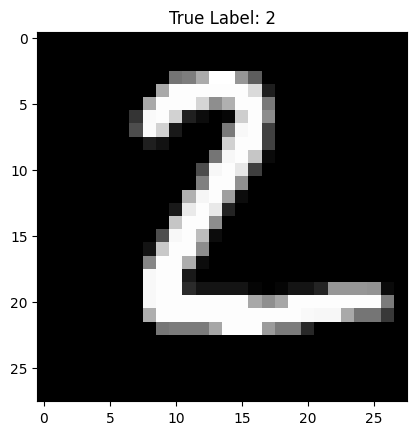

In [26]:
#plot original image
plt.imshow(X.numpy(), cmap='gray')
plt.title(f'True Label: {y.item()}')
plt.show()

<BarContainer object of 10 artists>

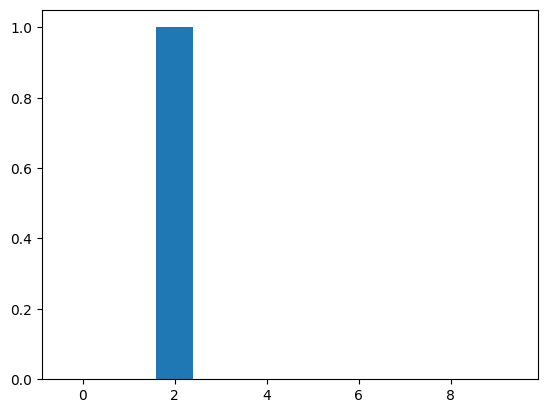

In [27]:
#get prediction of teach model
teacher_output = teacher_model(X.unsqueeze(0).unsqueeze(0).float())
#plot the teach output
plt.bar(range(10), nn.functional.softmax(teacher_output, dim=1).detach().numpy()[0])

In [28]:
#create adversarial example

_, _, x_adv = create_fgsm_adversarial_example(teacher_model, teacher_loss, X.unsqueeze(0).unsqueeze(0).float(), torch.tensor([y]), epsilon=0.1)

gradient is here
tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.,

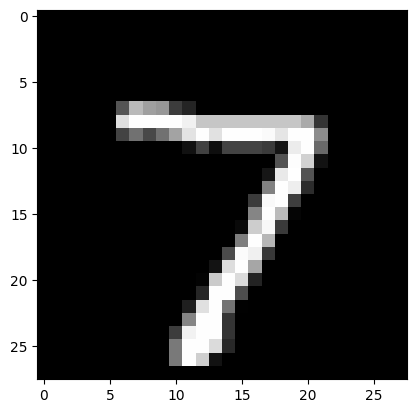

In [18]:
#plot adversarial image
plt.imshow(x_adv.squeeze().detach().numpy(), cmap='gray')

In [121]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data.grad.data
        
        def fgsm_attack(image, epsilon, data_grad):
            # Collect the element-wise sign of the data gradient
            sign_data_grad = data_grad.sign()
            # Create the perturbed image by adjusting each pixel of the input image
            perturbed_image = image + epsilon*sign_data_grad
            # Adding clipping to maintain [0,1] range
            perturbed_image = torch.clamp(perturbed_image, 0, 1)
            # Return the perturbed image
            return perturbed_image

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc}")

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [122]:
#convert test loader to batch size 1
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=1, shuffle=True)

In [123]:
test(student_model, device, test_loader, 0.3)   

Epsilon: 0.3	Test Accuracy = 84 / 500 = 0.168


(0.168,
 [(7,
   9,
   array([[0.3       , 0.3       , 0.3       , 0.3       , 0.3       ,
           0.3       , 0.3       , 0.3       , 0.3       , 0.3       ,
           0.3       , 0.3       , 0.3       , 0.3       , 0.3       ,
           0.        , 0.        , 0.3       , 0.3       , 0.3       ,
           0.3       , 0.        , 0.        , 0.3       , 0.3       ,
           0.3       , 0.3       , 0.        ],
          [0.3       , 0.3       , 0.        , 0.3       , 0.        ,
           0.3       , 0.        , 0.3       , 0.        , 0.3       ,
           0.        , 0.3       , 0.        , 0.3       , 0.        ,
           0.        , 0.3       , 0.3       , 0.3       , 0.3       ,
           0.        , 0.        , 0.        , 0.3       , 0.        ,
           0.        , 0.        , 0.        ],
          [0.3       , 0.3       , 0.3       , 0.3       , 0.        ,
           0.        , 0.        , 0.        , 0.        , 0.        ,
           0.        , 0.       

In [124]:
teach_accuracies = []
examples = []

epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(teacher_model, device, test_loader, eps)
    teach_accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 488 / 500 = 0.976
Epsilon: 0.05	Test Accuracy = 474 / 500 = 0.948
Epsilon: 0.1	Test Accuracy = 451 / 500 = 0.902
Epsilon: 0.15	Test Accuracy = 383 / 500 = 0.766
Epsilon: 0.2	Test Accuracy = 284 / 500 = 0.568
Epsilon: 0.25	Test Accuracy = 135 / 500 = 0.27
Epsilon: 0.3	Test Accuracy = 45 / 500 = 0.09
Epsilon: 0.4	Test Accuracy = 9 / 500 = 0.018
Epsilon: 0.5	Test Accuracy = 10 / 500 = 0.02
Epsilon: 0.6	Test Accuracy = 15 / 500 = 0.03
Epsilon: 0.7	Test Accuracy = 16 / 500 = 0.032
Epsilon: 0.8	Test Accuracy = 24 / 500 = 0.048
Epsilon: 0.9	Test Accuracy = 31 / 500 = 0.062
Epsilon: 1.0	Test Accuracy = 33 / 500 = 0.066


In [125]:
stu_acc = []
examples = []

epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(student_model, device, test_loader, eps)
    stu_acc.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 485 / 500 = 0.97
Epsilon: 0.05	Test Accuracy = 466 / 500 = 0.932
Epsilon: 0.1	Test Accuracy = 429 / 500 = 0.858
Epsilon: 0.15	Test Accuracy = 372 / 500 = 0.744
Epsilon: 0.2	Test Accuracy = 288 / 500 = 0.576
Epsilon: 0.25	Test Accuracy = 173 / 500 = 0.346
Epsilon: 0.3	Test Accuracy = 84 / 500 = 0.168
Epsilon: 0.4	Test Accuracy = 9 / 500 = 0.018
Epsilon: 0.5	Test Accuracy = 4 / 500 = 0.008
Epsilon: 0.6	Test Accuracy = 7 / 500 = 0.014
Epsilon: 0.7	Test Accuracy = 17 / 500 = 0.034
Epsilon: 0.8	Test Accuracy = 30 / 500 = 0.06
Epsilon: 0.9	Test Accuracy = 36 / 500 = 0.072
Epsilon: 1.0	Test Accuracy = 47 / 500 = 0.094


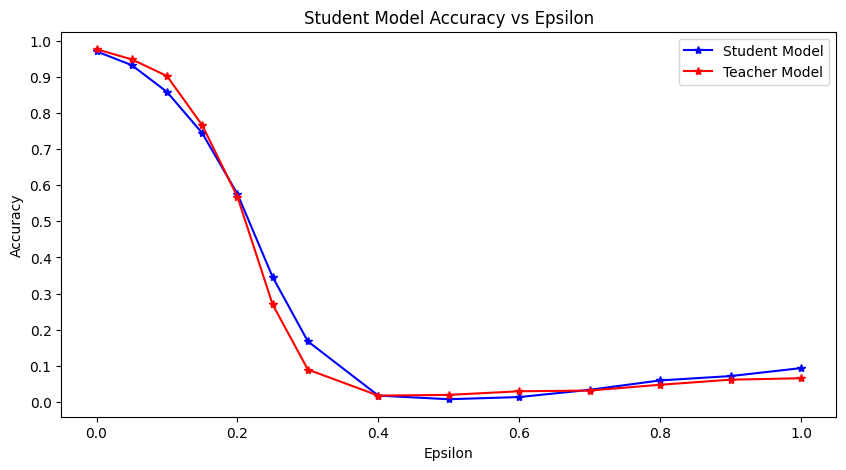

In [126]:
#plot the accuracies
plt.figure(figsize=(10, 5))
plt.plot(epsilons, stu_acc, 'b*-', label='Student Model')
plt.plot(epsilons, teach_accuracies, 'r*-', label='Teacher Model')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.title('Student Model Accuracy vs Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

